In [4]:
#  Imports
import tensorflow as tf
from tensorflow.keras.applications import incpetionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


ImportError: cannot import name 'incpetionV3' from 'tensorflow.keras.applications' (/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/applications/__init__.py)

In [2]:
#  Configurations
img_size = (224, 224)
batch_size = 32
input_shape = img_size + (3,)
train_dir = r'/kaggle/input/skin-cancer/skin dataset/train'
#val_dir = r'F:\taufeeq\pre_train_origanl\simple_augment_orignal\val'
test_dir = r'/kaggle/input/skin-cancer/skin dataset/test'


In [3]:
# -------------------------------
# Image Data Generators with split
# -------------------------------
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# -------------------------------
# Create Train & Validation sets
# -------------------------------
train_ds = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',     # 80% of images
    shuffle=True
)

val_ds = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',   # 20% of images
    shuffle=False
)

# -------------------------------
# Test set (remains unchanged)
# -------------------------------
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_ds.num_classes


Found 2820 images belonging to 4 classes.
Found 703 images belonging to 4 classes.
Found 1459 images belonging to 4 classes.


In [4]:
#  Load Pretrained Model (MobileNet)
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


I0000 00:00:1761637183.525872      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761637183.526657      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
#  Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#model.summary()


In [6]:
#  Training
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1761637199.216215     120 service.cc:148] XLA service 0x796328127870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761637199.217508     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761637199.217528     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761637199.838926     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/89 ━━━━━━━━━━━━━━━━━━━━ 15:03 10s/step - accuracy: 0.2812 - loss: 2.0306

I0000 00:00:1761637204.016715     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.3645 - loss: 1.4219 - val_accuracy: 0.5633 - val_loss: 1.0761 - learning_rate: 1.0000e-04
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 737ms/step - accuracy: 0.6306 - loss: 0.8967 - val_accuracy: 0.6117 - val_loss: 0.9522 - learning_rate: 1.0000e-04
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 643ms/step - accuracy: 0.7068 - loss: 0.7681 - val_accuracy: 0.6387 - val_loss: 0.8818 - learning_rate: 1.0000e-04
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 645ms/step - accuracy: 0.7367 - loss: 0.6672 - val_accuracy: 0.6600 - val_loss: 0.8407 - learning_rate: 1.0000e-04
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 655ms/step - accuracy: 0.7580 - loss: 0.6387 - val_accuracy: 0.6472 - val_loss: 0.8595 - learning_rate: 1.0000e-04
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 632ms/step - accuracy: 0.7732 - loss: 0.5820 - val_accuracy: 0.6814 - val_loss: 0.8054 - learning_rate: 1.0000e-04
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 658ms/step - accuracy: 0.7916

In [7]:
#  Evaluation
evaluation = model.evaluate(test_ds)
print("Evaluation results:", evaluation)


46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 647ms/step - accuracy: 0.7886 - loss: 0.5732
Evaluation results: [0.6879362463951111, 0.7347498536109924]


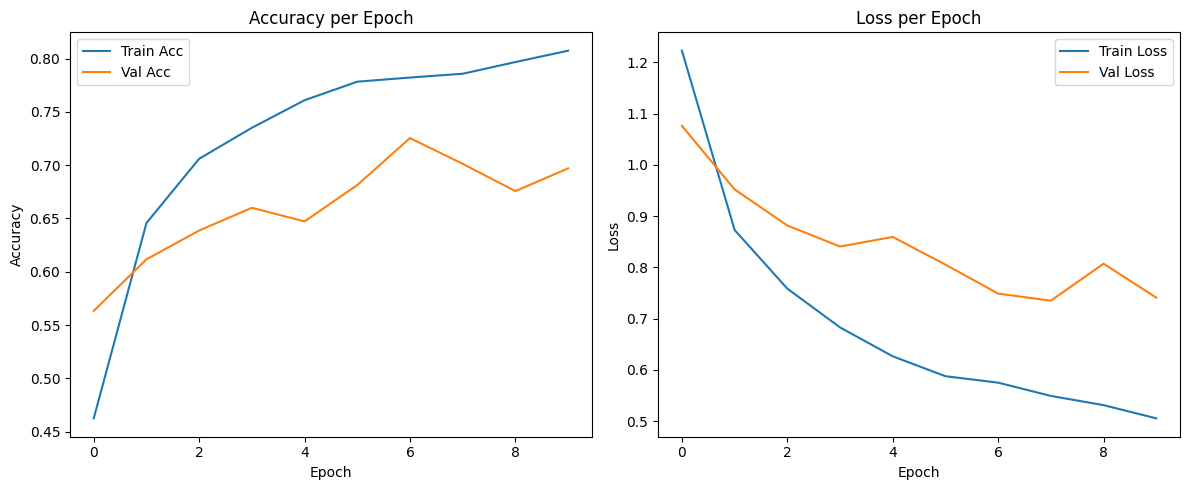

In [8]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step


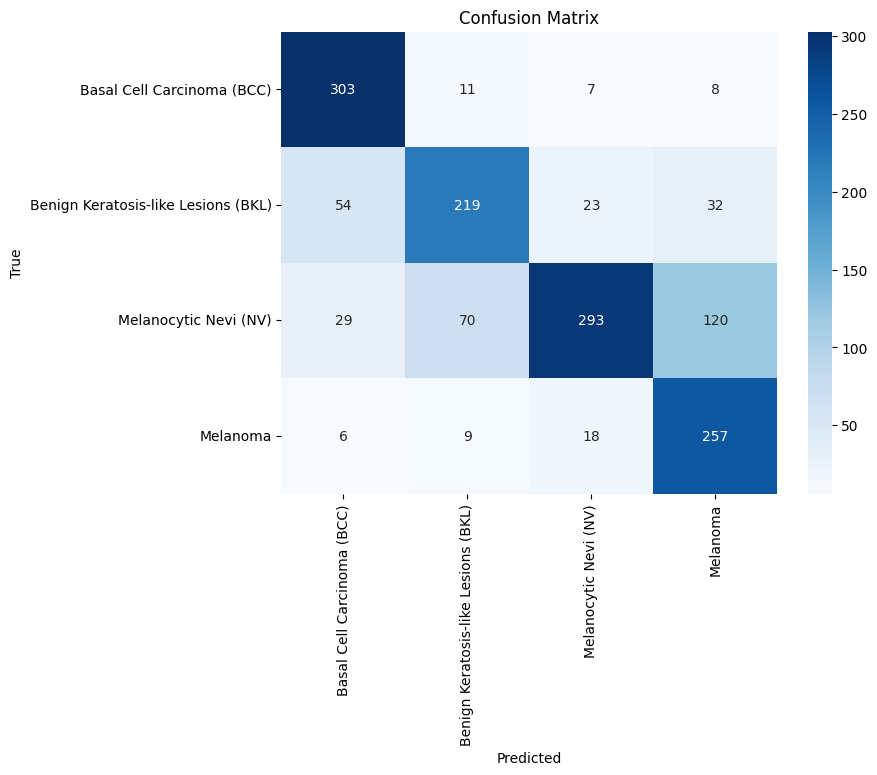

In [9]:
#  Evaluation: Confusion Matrix & All Metrics
test_ds.reset()
pred_probs = model.predict(test_ds, steps=len(test_ds), verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# True labels
y_true = []
for i in range(len(test_ds)):
    _, labels = test_ds[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Metrics: Accuracy, Precision, Recall, F1
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


Accuracy:  0.7347
Precision: 0.7577
Recall:    0.7347
F1-Score:  0.7297


In [11]:
#  Detailed Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                                     precision    recall  f1-score   support

         Basal Cell Carcinoma (BCC)       0.77      0.92      0.84       329
Benign Keratosis-like Lesions (BKL)       0.71      0.67      0.69       328
              Melanocytic Nevi (NV)       0.86      0.57      0.69       512
                           Melanoma       0.62      0.89      0.73       290

                           accuracy                           0.73      1459
                          macro avg       0.74      0.76      0.74      1459
                       weighted avg       0.76      0.73      0.73      1459



In [14]:
model.save('/kaggle/working/MobileNetV1_skin.h5')
print(" Model saved to /kaggle/working/MobileNetV1_skin.h5")

 Model saved to /kaggle/working/MobileNetV1_skin.h5


Model loaded.
Inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer>]
Input shapes: (None, 224, 224, 3)


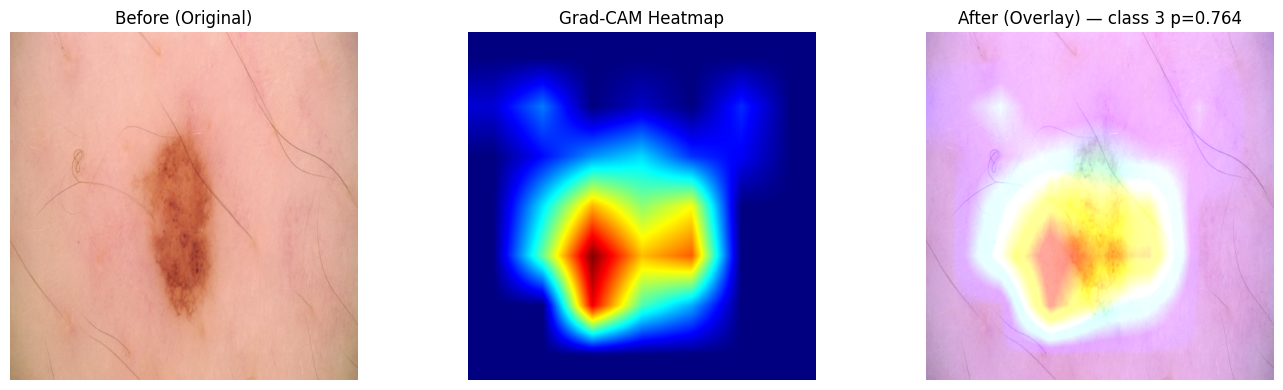

Saved:
  gradcam_results/ISIC_6663112_original.png
  gradcam_results/ISIC_6663112_heatmap.png
  gradcam_results/ISIC_6663112_overlay.png
Used conv layer: conv_pw_13
Pred class: 3


In [18]:
# ============================================
# Grad-CAM for Multi-Input Keras/TensorFlow .h5
# Compatible with TF 2.x / Keras 2.x/3.x + NumPy 2.x
# ============================================
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

# -------- CONFIG: EDIT THESE --------

MODEL_PATH = r"/kaggle/working/MobileNetV1_skin.h5"
IMG_PATH   = r"/kaggle/input/skin-cancer/skin dataset/test/Melanoma/ISIC_6663112.jpg"

SAVE_RESULTS = True
RESULTS_DIR  = "gradcam_results"
# If auto-detect picks the wrong conv layer, set it explicitly:
LAST_CONV_LAYER_NAME = None   # e.g., "conv5_block3_out"
SCALE_INPUT_0_1 = True        # divide by 255 if True
# -----------------------------------

os.makedirs(RESULTS_DIR, exist_ok=True)

def read_image_as_rgb(path):
    """Robust reader: handles BMP/JPG/PNG, grayscale, alpha."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    if len(img.shape) == 2:  # grayscale (H,W)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # BGRA
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    else:                    # BGR
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb  # uint8

def preprocess_for_shape(img_rgb, target_hw, channels, scale_0_1=True):
    """Resize to (H,W), set channels (1 or 3), return (1,H,W,C) float32."""
    H, W = target_hw
    arr = cv2.resize(img_rgb, (W, H), interpolation=cv2.INTER_AREA)

    if channels == 1:
        # convert to grayscale and keep single channel
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        arr = gray[..., None]
    elif channels == 3:
        # ensure RGB 3 channels
        if arr.ndim == 2:
            arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
        else:
            # already RGB
            pass
    else:
        # uncommon case: pass-through but ensure channel count matches
        if arr.shape[-1] != channels:
            # Attempt to adapt by repeat or truncate
            if arr.shape[-1] == 1 and channels > 1:
                arr = np.repeat(arr, channels, axis=-1)
            elif arr.shape[-1] == 3 and channels == 1:
                arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)[..., None]
            else:
                raise ValueError(f"Unsupported channel mapping: input has 3, model expects {channels}")

    arr = arr.astype("float32")
    if scale_0_1:
        arr /= 255.0
    arr = np.expand_dims(arr, axis=0)  # (1,H,W,C)
    return arr

def prepare_model_inputs(model, img_rgb, scale_0_1=True):
    """
    Prepares a list of input arrays matching model.inputs.
    Supports single- or multi-input models with 4D image tensors.
    """
    inputs = model.inputs  # list(tensors) or tensor
    if not isinstance(inputs, (list, tuple)):
        inputs = [inputs]

    prepared = []
    for it in inputs:
        ishape = it.shape  # (None,H,W,C) or possibly dynamic
        # Extract expected H,W,C (handle None)
        if len(ishape) != 4:
            raise ValueError(f"Expected 4D image input, got shape {ishape} for input {it.name}")
        H = int(ishape[1]) if ishape[1] is not None else img_rgb.shape[0]
        W = int(ishape[2]) if ishape[2] is not None else img_rgb.shape[1]
        C = int(ishape[3]) if ishape[3] is not None else 3
        arr = preprocess_for_shape(img_rgb, (H, W), C, scale_0_1)
        prepared.append(arr)

    # If single-input, return arr directly; else return list
    return prepared[0] if len(prepared) == 1 else prepared

def find_last_conv_layer_name(model, fallback=None):
    """
    Returns the name of the last Conv2D-like layer in the model (searches nested).
    If fallback provided, returns that instead.
    """
    if fallback:
        return fallback

    conv_types = (tf.keras.layers.Conv2D,
                  tf.keras.layers.SeparableConv2D,
                  tf.keras.layers.DepthwiseConv2D)

    # Flatten all layers, including nested models
    all_layers = []
    def collect_layers(m):
        for layer in m.layers:
            all_layers.append(layer)
            # recurse into nested models
            if hasattr(layer, "layers"):
                collect_layers(layer)
    collect_layers(model)

    for layer in reversed(all_layers):
        if isinstance(layer, conv_types):
            return layer.name

    raise ValueError("Could not auto-detect a Conv2D-like layer. Please set LAST_CONV_LAYER_NAME manually.")

def build_grad_model(model, last_conv_layer_name):
    """
    Builds a model that maps original model inputs -> (conv_feature_map, predictions).
    Works for single- and multi-input models.
    """
    conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[conv_layer.output, model.output]
    )
    return grad_model

def make_gradcam_heatmap(model, grad_model, model_inputs, class_index=None):
    """
    Computes Grad-CAM++ heatmap for given inputs.
    model_inputs: array or list of arrays matching model.inputs
    """
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(model_inputs, training=False)
                if class_index is None:
                    class_index = int(tf.argmax(predictions[0]).numpy())
                target = predictions[:, class_index]

            grads = tape3.gradient(target, conv_outputs)             # 1st derivative
        grads2 = tape2.gradient(grads, conv_outputs)                 # 2nd derivative
    grads3 = tape1.gradient(grads2, conv_outputs)                    # 3rd derivative

    conv_outputs = conv_outputs[0].numpy()                           # (Hc, Wc, C)
    grads = grads[0].numpy()
    grads2 = grads2[0].numpy()
    grads3 = grads3[0].numpy()

    # Eqn from Grad-CAM++ paper: α = grads² / (2*grads² + Σ(conv * grads³))
    numerator = grads2
    denominator = 2.0 * grads2 + (conv_outputs * grads3)
    denominator = np.where(denominator != 0.0, denominator, 1e-10)
    alphas = numerator / denominator

    # Normalization across spatial dimensions
    weights = np.sum(alphas * np.maximum(grads, 0.0), axis=(0, 1))

    # Weighted combination of feature maps
    cam = np.sum(weights * conv_outputs, axis=-1)

    # Normalize 0–1
    cam = np.maximum(cam, 0)
    if np.max(cam) > 0:
        cam /= np.max(cam)

    return cam.astype(np.float32), class_index, predictions.numpy()

def overlay_heatmap_on_image(orig_rgb, heatmap, alpha=0.35):
    """Resize heatmap to original, colorize, and overlay on the RGB image."""
    h, w = orig_rgb.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(orig_rgb, 1.0, heatmap_color, alpha, 0)
    return heatmap_color, overlay

def explain_one_image_multi_input(model, img_path, last_conv_layer_name=None,
                                  scale_input_0_1=True, save_dir=None, show=True):
    """Runs Grad-CAM on one image for (possibly) multi-input model."""
    # Read original RGB image
    orig_rgb = read_image_as_rgb(img_path)

    # Prepare model inputs
    model_inputs = prepare_model_inputs(model, orig_rgb, scale_0_1=scale_input_0_1)

    # Find conv layer to use
    last_conv = find_last_conv_layer_name(model, fallback=last_conv_layer_name)

    # Build grad model and compute heatmap
    grad_model = build_grad_model(model, last_conv)
    heatmap, used_class, preds = make_gradcam_heatmap(model, grad_model, model_inputs)

    # Create overlays
    heatmap_color, overlay = overlay_heatmap_on_image(orig_rgb, heatmap, alpha=0.60)

    # Show
    if show:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 3, 1); plt.imshow(orig_rgb); plt.title("Before (Original)"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(heatmap_color); plt.title("Grad-CAM Heatmap"); plt.axis("off")
        conf = float(preds[0][used_class]) if preds.ndim == 2 else float(np.max(preds))
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title(f"After (Overlay) — class {used_class} p={conf:.3f}"); plt.axis("off")
        plt.tight_layout(); plt.show()

    # Save
    if save_dir:
        base = os.path.splitext(os.path.basename(img_path))[0]
        p1 = os.path.join(save_dir, f"{base}_original.png")
        p2 = os.path.join(save_dir, f"{base}_heatmap.png")
        p3 = os.path.join(save_dir, f"{base}_overlay.png")
        # Save as RGB PNGs
        cv2.imwrite(p1, cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(p2, cv2.cvtColor(heatmap_color, cv2.COLOR_RGB2BGR))
        cv2.imwrite(p3, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        print(f"Saved:\n  {p1}\n  {p2}\n  {p3}")

    return {
        "predictions": preds[0],
        "used_class": used_class,
        "last_conv_layer": last_conv,
        "heatmap": heatmap
    }

# ---------- RUN ----------
model = load_model(MODEL_PATH, compile=False)
print("Model loaded.")
print("Inputs:", model.inputs)
print("Input shapes:", getattr(model, "input_shape", None))

result = explain_one_image_multi_input(
    model,
    IMG_PATH,
    last_conv_layer_name=LAST_CONV_LAYER_NAME,
    scale_input_0_1=SCALE_INPUT_0_1,
    save_dir=RESULTS_DIR if SAVE_RESULTS else None,
    show=True
)
print("Used conv layer:", result["last_conv_layer"])
print("Pred class:", result["used_class"])
